# D5 fat inflation

In [1]:
import sympy
from sympy.simplify.radsimp import collect_sqrt
import numpy as np
import inflatox
sympy.init_printing()

In [2]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

#A4 tufte layout paper figure sizes
MARGIN_FIG = lambda scale: (1.99, 1.99*scale)
MAIN_FIG = lambda scale: (4.18, 4.18*scale)
FULL_FIG = lambda scale: (6.64, 6.64*scale)

#Fontsize configuration
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', family='JetBrains Mono')
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#Other matplotlib configuration
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.autolayout'] = True
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1
plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Fira Code'
plt.rcParams['mathtext.it'] = 'Fira Code'
plt.ioff()

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


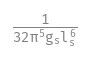

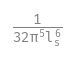

In [3]:
r, θ = sympy.symbols('r θ2')
fields = [r, θ]

gs, ls, N = sympy.symbols('g_s l_s N')
mu5, T5, Lt = sympy.symbols('mu5 T5 L_T')

mu5 = 1/((2 * sympy.pi)**5 * ls**6)
T5 = mu5 / gs

display(T5, mu5)

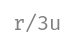

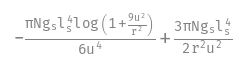

In [4]:
rho, u = sympy.symbols('rho u')
rho = r / (3*u)

H = (
  (sympy.pi*N*gs*ls**4)/(12*u**4) * (2/rho**2 - 2*sympy.ln(1/rho**2 +1))
).nsimplify().collect([u, r]).expand().powsimp(force=True)
display(rho, H)

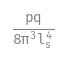

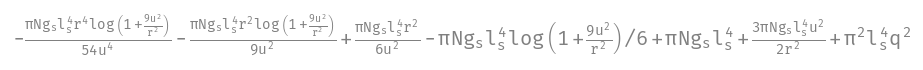

In [5]:
p, q = sympy.symbols('p q')

F = (
  H / 9 * (r**2 + 3*u**2)**2 + (sympy.pi*q*ls**2)**2
).nsimplify().collect([r, u]).expand().powsimp()

gamma = 4*sympy.pi**2*ls**2*p*q*T5*gs
display(gamma, F)

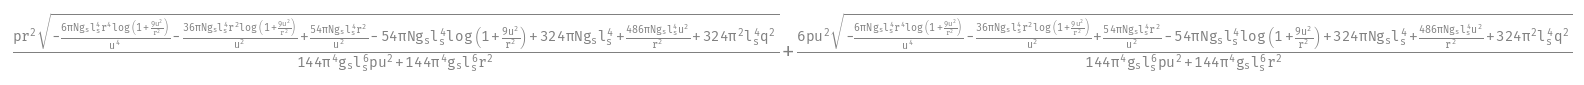

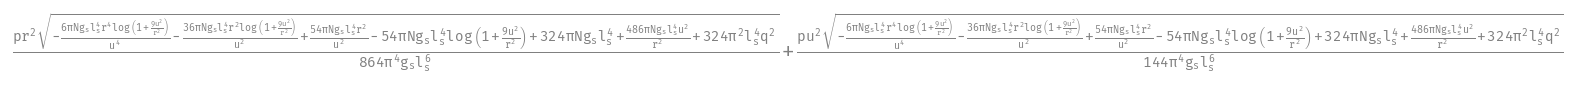

In [6]:
sqrtF = sympy.sqrt(F)
g00 = collect_sqrt(
  4*sympy.pi*p*T5 * sqrtF * ((r**2+6*u**2)/(r**2+p*u**2)),
evaluate=True).expand().powsimp()
g11 = collect_sqrt(
  (4/6) * sympy.pi*p*T5 * sqrtF * (r**2+6*u**2),
evaluate=True).nsimplify().collect([r, u]).expand().powsimp()

display(g00, g11)

metric = [
  [g00, 0],
  [0, g11]
]

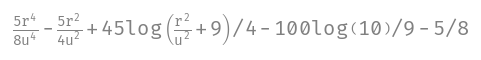

In [7]:
Phi_min = ( (5/72) * (
  81*(9*rho**2 - 2)*rho**2 +
  162*sympy.ln(9*(rho**2 + 1)) +
  -9 +
  -160*sympy.ln(10)
)).nsimplify().collect([u]).expand().powsimp()
display(Phi_min)

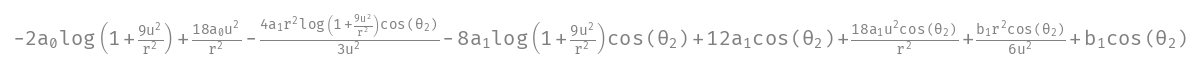

In [8]:
a0, a1, b1 = sympy.symbols('a0 a1 b1')
Phi_h = (a0 * (2/rho**2 -2*sympy.ln(1/rho**2 + 1))
  + 2*a1*(
    6 + 1/rho**2 -2*(2+3*rho**2)*sympy.ln(1 + 1/rho**2)
  )*sympy.cos(θ)
  + (b1/2) * (2+3*rho**2)*sympy.cos(θ)
).nsimplify().collect([u, r]).expand().powsimp()
display(Phi_h)

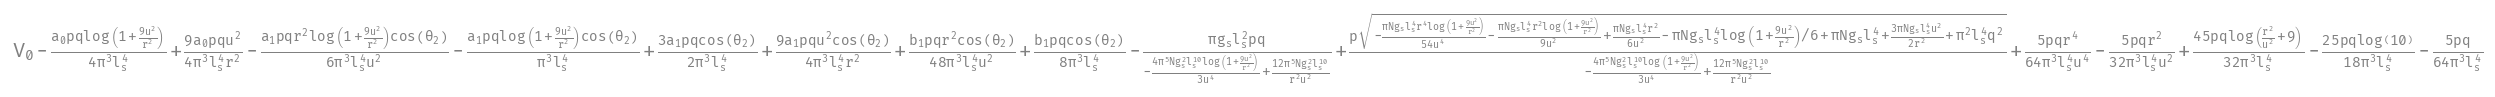

In [9]:
V0 = sympy.symbols('V0')
V = V0 + (4*sympy.pi*p*T5/H) * (sympy.sqrt(F)-(ls**2)*sympy.pi*q*gs) + gamma*(Phi_min + Phi_h)
V = V.nsimplify().collect([ls, gs]).expand().powsimp()
display(V)

In [12]:
#calculate da curvature
from einsteinpy.symbolic import MetricTensor, RicciScalar
metric_tensor = MetricTensor(metric, fields)
R = RicciScalar.from_metric(metric_tensor).simplify()
display(R)

In [10]:
hesse = inflatox.SymbolicCalculation.new_from_list(
  fields,
  metric,
  V,
  assertions=False,
  simplification_depth=1,
  silent=True
).execute([[0,1]])

Calculating covariant Hesse matrix...
Projecting the Hesse matrix on the vielbein basis...


In [11]:
out = inflatox.Compiler(hesse, cleanup=False).compile()
out.print_sym_lookup_table()

[Symbol Dictionary]
r -> x[0]
θ2 -> x[1]
V0 -> args[0]
a0 -> args[1]
p -> args[2]
q -> args[3]
u -> args[4]
l_s -> args[5]
a1 -> args[6]
b1 -> args[7]
g_s -> args[8]
N -> args[9]


In [12]:
from inflatox.consistency_conditions import AnguelovaLazaroiuCondition
anguelova = AnguelovaLazaroiuCondition(out)

V0 = -1.17e-8
N = 1000.0
gs = 0.01
ls = 501.961
u = 50*ls
q = 1.0
p = 5.0
a0 = 0.001
a1 = 0.0005
b1 = 0.001

parameters = np.array([V0, a0, p, q, u, ls, a1, b1, gs, N])
print(len(parameters))

10


In [18]:
density = 200
r_start, r_stop = 0.0, 36.0
θ_start, θ_stop = 0.0, 4*np.pi
N_r, N_θ = int(round((r_stop - r_start)*density)), int(round((θ_stop-θ_start)*density))
extent1 = (r_start, r_stop, θ_start, θ_stop)

array1 = anguelova.evaluate(parameters, *extent1, N_r, N_θ)

/tmp/ipykernel_6662/436846207.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('../out/d5fat.svg', transparent=True, bbox_inches="tight", pad_inches=0.05)
/tmp/ipykernel_6662/436846207.py:40: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


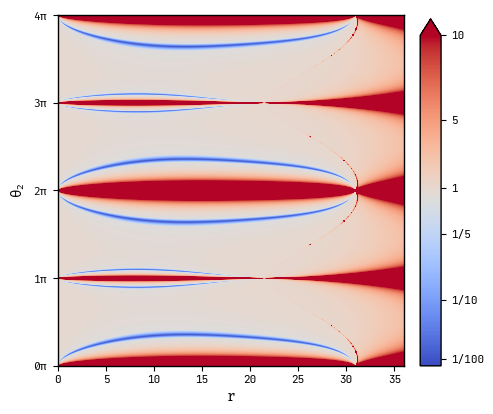

In [24]:
two_norm = mpl.colors.TwoSlopeNorm(0.25, vmax=10)
cmap = mpl.colormaps['coolwarm'].copy()
cmap.set_over(cmap(1.0))
cmap.set_bad(cmap(1.0))

fig, ax = plt.subplots(1, 1, figsize=MAIN_FIG(1))
img = ax.imshow(
  np.transpose(array1),
  extent=extent1,
  cmap=cmap,
  norm=two_norm,
  aspect='auto'
)
ax.set_yticks(
  [np.pi * x for x in range(0, 5)],
  labels=[f'${x}\pi$' for x in range(0, 5)]
)

#Make colorbar
cax = fig.add_axes([
  ax.get_position().x1+0.11,
  ax.get_position().y0+0.01,
  0.05,
  ax.get_position().height+0.06
], frameon=True)

cbar = plt.colorbar(
  img,
  extend='max',
  location='right',
  ticks=[1/100, 1/10, 1/5, 1, 5, 10],
  cax=cax
)
cax.set_yticklabels(['1/100','1/10','1/5', '1', '5', '10'])
cax.use_sticky_edges = True

ax.set_xlabel(f'${sympy.latex(fields[0])}$')
ax.set_ylabel(f'${sympy.latex(fields[1])}$')
fig.savefig('../out/d5fat.svg', transparent=True, bbox_inches="tight", pad_inches=0.05)
fig.show()

In [25]:
pot_calc = anguelova.calc_V_array(
  parameters,
  [r_start, θ_start],
  [r_stop, θ_stop],
  [N_r, N_θ]
)

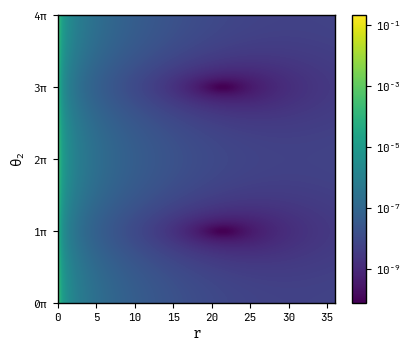

In [50]:
plt.figure(figsize=MAIN_FIG(0.85))
plt.imshow(np.transpose(pot_calc),
  extent=extent1,
  aspect='auto',
  norm=mpl.colors.LogNorm()
)
plt.yticks(
  [np.pi * x for x in range(0, 5)],
  labels=[f'${x}\pi$' for x in range(0, 5)]
)
plt.xlabel(f'${sympy.latex(fields[0])}$')
plt.ylabel(f'${sympy.latex(fields[1])}$')
plt.colorbar(location='right', aspect=20)
plt.savefig('../out/d5fatpot.svg', transparent=True, bbox_inches="tight", pad_inches=0.05)
plt.show()

/tmp/ipykernel_6662/785626476.py:39: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist=12
/tmp/ipykernel_6662/785626476.py:41: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.savefig('../out/d5fatpot3d.svg', transparent=True)


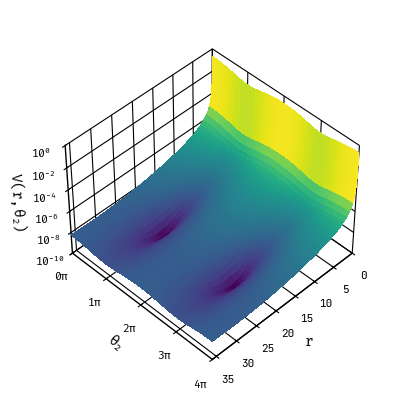

In [82]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=MAIN_FIG(1))
rs = np.linspace(r_start, r_stop, N_r)
θs = np.linspace(θ_start, θ_stop, N_θ)

ax.plot_surface(
  *np.meshgrid(rs, θs),
  np.log10(np.transpose(pot_calc)),
  linewidth=0,
  antialiased=False,
  cmap='viridis'
)

ax.set_xlabel(f'${sympy.latex(fields[0])}$')
ax.set_ylabel(f'${sympy.latex(fields[1])}$')
ax.set_zlabel(f'$V({sympy.latex(fields[0])},{sympy.latex(fields[1])})$')

ax.set_yticks(
  [np.pi * x for x in range(0, 5)],
  labels=[f'${x}\pi$' for x in range(0, 5)]
)
ax.set_zticks(
  [-2*x for x in range(0, 6)],
  [f'$10^{{{-2*x}}}$' for x in range(0, 6)]
)
ax.set_zlim(-10, 0)
ax.set_xlim(0, 36)
ax.set_ylim(0, 4*np.pi)

wit, zwart = (1.0, 1.0, 1.0, 0.0), (0.0, 0.0, 0.0, 1.0)
ax.xaxis.set_pane_color(wit)
ax.yaxis.set_pane_color(wit)
ax.zaxis.set_pane_color(wit)

ax.xaxis._axinfo["grid"]['color'] = zwart
ax.yaxis._axinfo["grid"]['color'] = zwart
ax.zaxis._axinfo["grid"]['color'] = zwart

ax.view_init(45, 45)
ax.dist=12

fig.savefig('../out/d5fatpot3d.svg', transparent=True)
fig